# Predição do Estado de uma Smart Grid

## Bibliotecas

In [67]:
# Biblioteca para coletar os dados da rede simulada
from ucimlrepo import fetch_ucirepo 

# Bibliotecas para análise e manipulação dos dados
import numpy as np
import pandas as pd
import seaborn as sns

# Charts and Visualization
from matplotlib import pyplot as plt

# Machine Learning Libraries
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR
from sklearn.linear_model import RidgeCV
from tpot.builtins import StackingEstimator



# Domínio da Aplicação

## Exploração da Base de Dados

### Coletando os [dados simulados de estabilidade de uma rede elétrica](https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data)

In [49]:
electrical_grid_stability_simulated_data = fetch_ucirepo(id=471).data

features = electrical_grid_stability_simulated_data.features 
targets = electrical_grid_stability_simulated_data.targets

data = pd.merge(features, targets, left_index=True, right_index=True, how='outer')

### Explicando os Atributos

- tau[x]: Tempo de reação do participante (valor real no intervalo [0.5, 10] segundos). 
    - tau1 - o valor para o produtor de eletricidade;
- p[x]: Potência nominal consumida (negativa) ou produzida (positiva) (valor real). 
    - Para consumidores, no intervalo [-0.5, -2] segundos^-2;
    - p1 = abs(p2 + p3 + p4);
- g[x]: Coeficiente (gamma) proporcional à elasticidade de preço (valor real no intervalo [0.05, 1] segundos^-1). 
    - g1 - o valor para o produtor de eletricidade;
- stab: A parte real máxima da raiz da equação característica (se positiva - o sistema é linearmente instável) (valor real).
- stabf: A classificação de estabilidade do sistema (categórica: estável/instável).


### Visualização os Dados

In [50]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


# Pré-Processamento dos Dados

### Eliminação do dado discreto, `stabf`

Com o objetivo de prever o próximo estado da rede, a partir do valor contínuo `stab`, temos que eliminar o valor `stabf` já que depende de `stab`.

In [51]:
data.drop(columns=['stabf'], inplace=True)

### Análise das Correlações

Analisar as correlações das váriaveis para escolher as melhores váriaveis para os modelos de regressão.

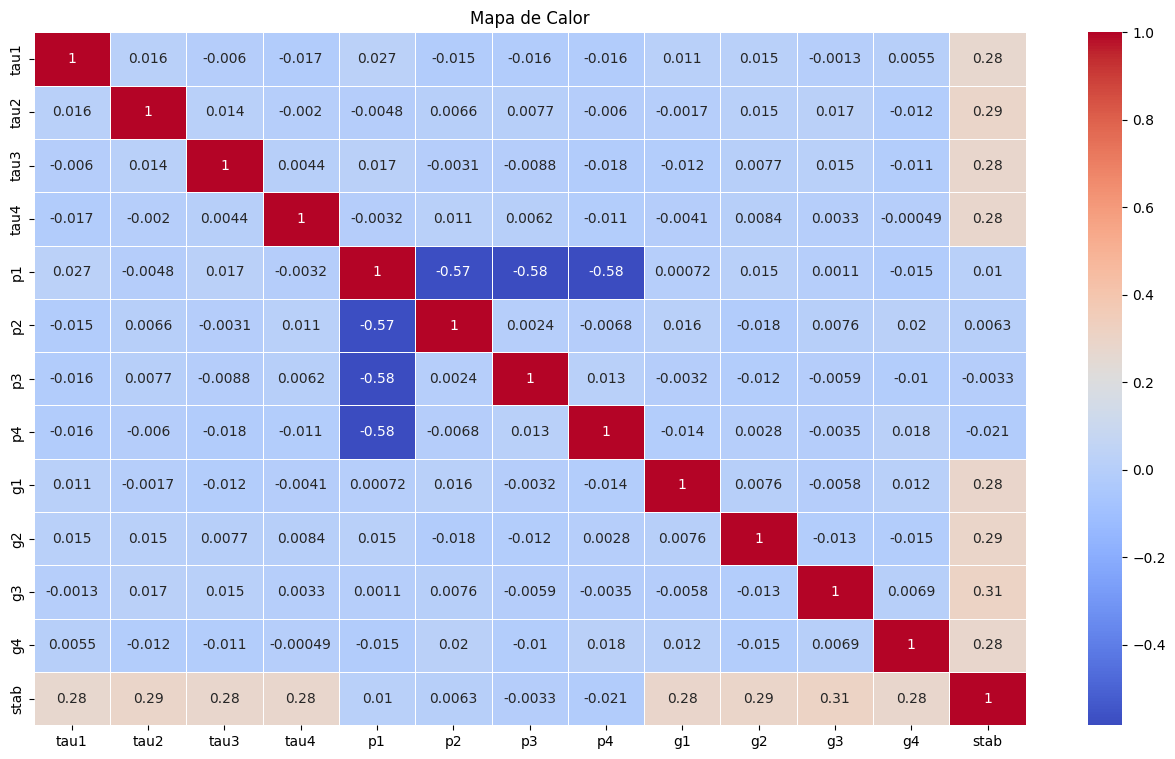

In [52]:
correlation_matrix = data.corr()

plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor')
plt.show()

## Limpeza os dados

Vendo a baixa correlação das variáveis $p_x$ com $stab$, é decidido a remoção desses valores, para melhorar o modelo.

In [53]:
data.drop(columns=['p1', 'p2', 'p3', 'p4'], inplace=True)

# Reconhecimento de Padrões e Aprendizados

## Definição de Métodos e Classes de Apoio

In [76]:
def create_error_structure():
    return {
        "r2": [],
        "mse": [],
        "mae": [],
        "pred": [],
        "test": [],
        "mape": [],
    }

def get_class_name(object):
    return object.__class__.__name__

class Fitter:
    def __init__(self, x_train, y_train, x_test, y_test) -> None:
        self.__x_train = x_train
        self.__y_train = y_train
        self.__x_test = x_test
        self.__y_test = y_test

    def fit_model_and_measure(self, model, data):
        model.fit(self.__x_train, self.__y_train)
        
        pred = model.predict(self.__x_test)

        data['pred'].append(pred)
        data['test'].append(self.__y_test)
        data['r2'].append(r2_score(self.__y_test, pred))
        data['mse'].append(mean_squared_error(self.__y_test, pred))
        data['mae'].append(mean_absolute_error(self.__y_test, pred))
        data['mape'].append(np.mean(np.abs((self.__y_test - pred) / self.__y_test)) * 100)

MODELS = [
    # SVR(),
    # LGBMRegressor(max_depth=10),
    # linear_model.Lasso(alpha=0.1),
    # #xgboost.sklearn.XGBRegressor(),#earning_rate=0.1, max_depth=7, min_child_weight=9, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.35, verbosity=0),
    # KNeighborsRegressor(n_neighbors=5),
    # RandomForestRegressor(n_estimators=100, random_state=0),
    # DecisionTreeRegressor(max_depth=5, splitter='random', min_samples_leaf=5),
    make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    StackingEstimator(estimator=RidgeCV()),
    StackingEstimator(estimator=LinearSVR(C=25.0, dual=False, epsilon=0.0001, loss="squared_epsilon_insensitive", tol=0.01)),
    XGBRegressor(learning_rate=0.1, max_depth=8, min_child_weight=13, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.8, verbosity=0)
    )
]

## Treinamento e Validação dos Modelos

In [77]:
outputs = {}

for model in MODELS:
    outputs[get_class_name(model)] = create_error_structure()
 
# K-Fold para divisão dos dados
five_folds = KFold(n_splits=5, random_state=0, shuffle=True)

# Índice da coluna de 'stab'
STAB_COLUMN_INDEX = list(data.columns).index('stab')

# Loop sobre os folds
for index, (train_index, test_index) in enumerate(five_folds.split(data)):
    y_train = data.values[train_index][:, STAB_COLUMN_INDEX]
    x_train = data.values[train_index]
    x_train = np.delete(x_train, STAB_COLUMN_INDEX, 1)

    y_test = data.values[test_index][:, STAB_COLUMN_INDEX]
    x_test = data.values[test_index]
    x_test = np.delete(x_test, STAB_COLUMN_INDEX, 1)

    fitter = Fitter(
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test,
    )

    for model in MODELS:
        fitter.fit_model_and_measure(model, data=outputs[get_class_name(model)])

# Pós-Processamento e Conclusão

## Definindo funções de apoio

In [70]:
def create_metrics(error_structure):
    metrics = {
        'MSE': error_structure['mse'], 
        'MAE': error_structure['mae'], 
        'MAPE': error_structure['mape'],
        'R2': error_structure['r2']  # Adicionando a métrica r2
    }

    print(metrics)

    mean_std = {metric: (np.mean(scores), np.std(scores)) for metric, scores in metrics.items()}

    return mean_std

{'MSE': [np.float64(3.404371461268403e-05), np.float64(4.538233820228893e-05), np.float64(4.100906013841925e-05), np.float64(3.8694533489422864e-05), np.float64(3.9956656636209357e-05)], 'MAE': [np.float64(0.0042442171272965125), np.float64(0.004731870453640592), np.float64(0.004552370772221474), np.float64(0.004469082154304045), np.float64(0.0045460180762059935)], 'MAPE': [np.float64(2306.381739638872), np.float64(40.11638025141512), np.float64(61.41723671036652), np.float64(59.387614573695124), np.float64(160.6648960217583)], 'R2': [0.9752571059862283, 0.9676988462221675, 0.9702699011402828, 0.9698899564248433, 0.9707622479840692]}


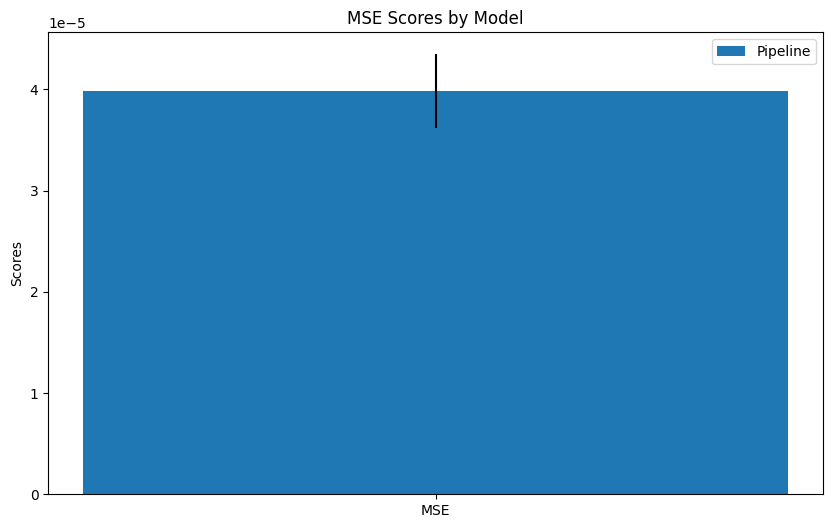

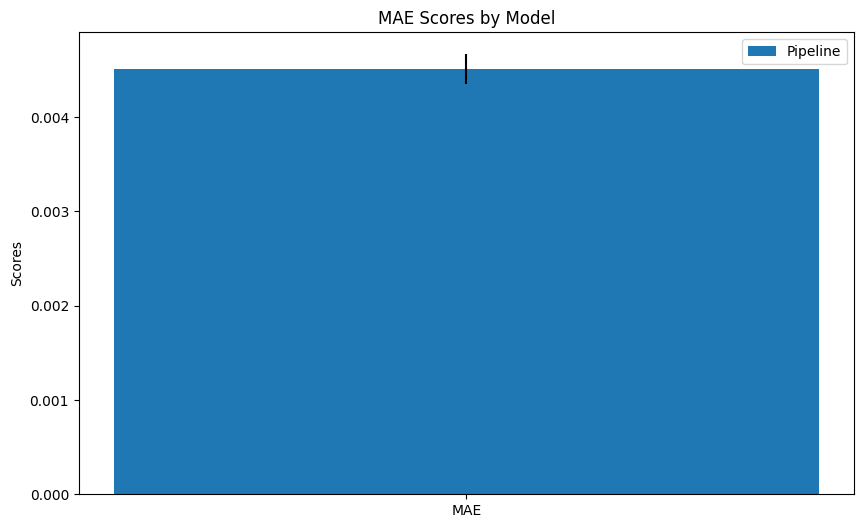

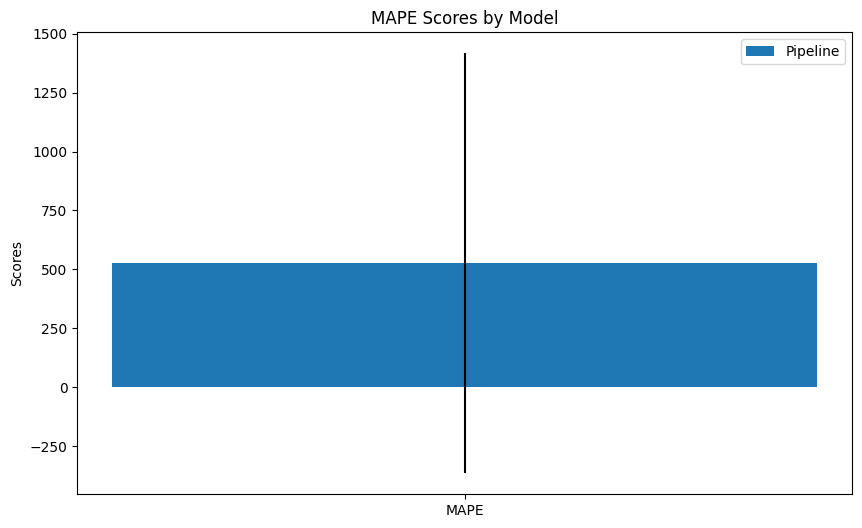

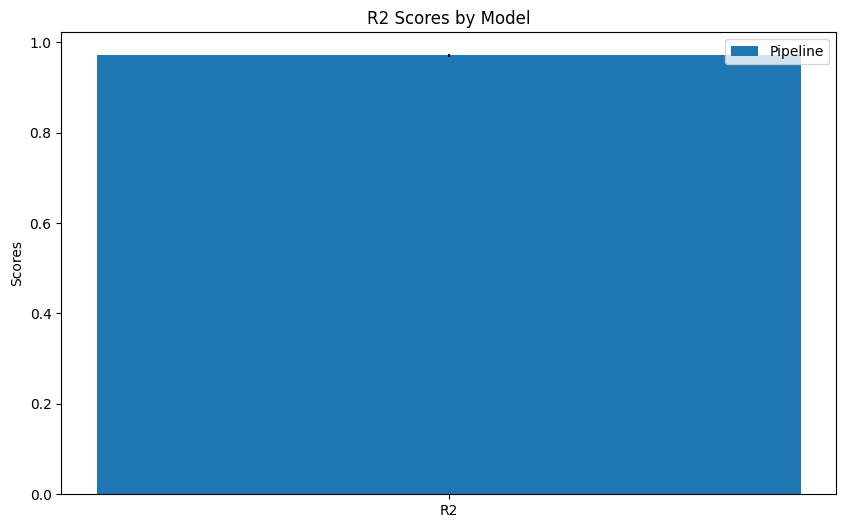


Pipeline Metrics:
Mean MSE: 0.0000
Mean MAE: 0.0045
Mean MAPE: 525.5936
Mean R2: 0.9708


In [78]:
model_metrics = {}

for model in MODELS:
    model_metrics[get_class_name(model)] = create_metrics(outputs[get_class_name(model)])

# Função para plotar gráficos de métricas
def plot_metrics(metric_name, model_metrics, labels):
    width = 0.2
    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (model_name, metric_values) in enumerate(model_metrics.items()):
        rects = ax.bar(x + i * width, [metric_values[metric_name][0] for metric_name in labels], width, label=model_name, yerr=[metric_values[metric_name][1] for metric_name in labels])

    ax.set_ylabel('Scores')
    ax.set_title(f'{metric_name} Scores by Model')
    ax.set_xticks(x + width * (len(model_metrics) - 1) / 2)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

# Labels de métricas
metrics_to_plot = ['MSE', 'MAE', 'MAPE', 'R2']

# Plotar gráficos para cada métrica
for metric in metrics_to_plot:
    plot_metrics(metric, model_metrics, [metric])

# Exibindo as médias de cada modelo
for model_name, model_mean_std in model_metrics.items():
    print(f"\n{model_name} Metrics:")
    for metric in metrics_to_plot:
        print(f"Mean {metric}: {model_mean_std[metric][0]:.4f}")

# Conclusão

Responder à pergunta: "Você acredita que será possível entregar tudo que prometeu no documento da Proposta?"


Sim, por mais que esteja apenas no começo do projeto, já é possivel fazer algumas análises utilizando regressão linear e arvore de regressão como visto em aula, com o que já temos fica facil crial pipelines para os ajustes nos dados e também abre a possibilidade para random forests. Com o objetivo final de evitar overfitting e garantir também que seja possivel obter respostas e tomadas de decisões razoáveis em relação aos dados estabelecidos.